In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from tiramisu import create_tiramisu

Using TensorFlow backend.


In [2]:
def get_image_names(base_name):
    score_file_name = f'../data/{base_name}.png'
    mask_file_name = f'../data/{base_name}_mask.png'
    return score_file_name, mask_file_name

def get_images(base_name):
    score_file_name, mask_file_name = get_image_names(base_name)
    mask_image = Image.open(mask_file_name).convert('L')
    mask_image = Image.eval(mask_image, lambda x: x*10) # saturate the mask
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image, mask_image

def get_input_prediction_tiles(input_image):
    # cannot just send an image to predict.  We have to send the tiles
    # pred_result = model.predict(score_image)
    #   ValueError: Error when checking : expected input_1 to have shape (None, 64, 64, 1) 
    #   but got array with shape (1, 1123, 794, 1)
    num_tiles = np.ceil(np.array([input_image.width/64,input_image.height/64]))
    tot_tiles = int(num_tiles[0]*num_tiles[1])
    input_tiles = np.zeros((tot_tiles,64,64,1),dtype='uint8')
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            input_tiles[i] = np.array(score_image.crop([ix*64,iy*64,(ix+1)*64,(iy+1)*64])).reshape(64,64,1)
            i += 1
    return input_tiles

def image_from_tiles(width,height,pred_tiles,pred_channel):
    # reshape & collect a single channel plane to visualize
    pred_tiles = pred_tiles.reshape(input_tiles.shape[0],64,64,2)
    pred_one_tiles = pred_tiles[:,:,:,1]#pred_one = pred_one.reshape(int(num_tiles[0])*64,int(num_tiles[1])*64)
    num_tiles = np.ceil(np.array([width/64,height/64]))
    pred_one = Image.new('L', (int(num_tiles[0])*64,int(num_tiles[1])*64), (0,))
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            pred_tile_image = Image.fromarray(np.uint8(pred_one_tiles[i]*255))
            pred_one.paste(pred_tile_image, (ix*64,iy*64))
            i += 1
    return pred_one

In [3]:
with open("data/results/model_171015.json","r") as f:
    json_string = f.read()
model = model_from_json(json_string)

In [4]:
# supposed to be best model
model.load_weights("data/results/mask_weights_171016_094411.h5")
# last model from last night
#model.load_weights("data/results/mask_weights_171015_231421.h5")

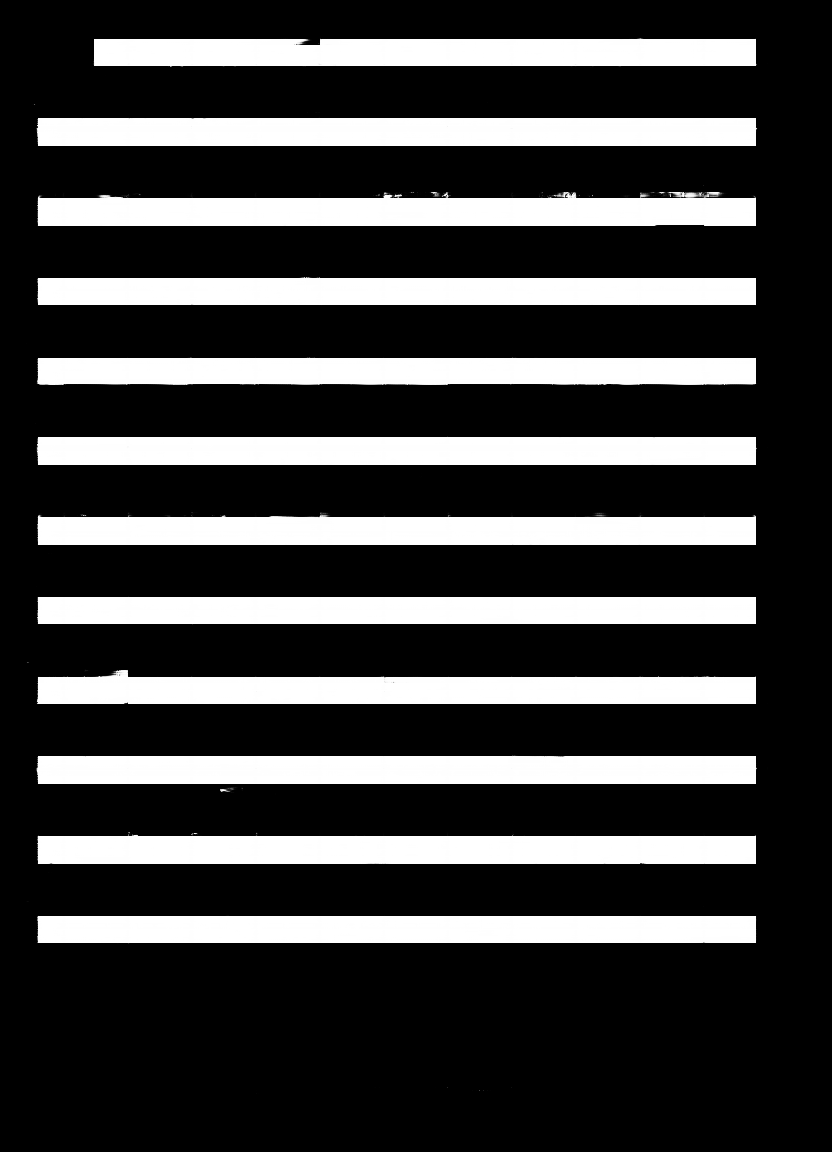

In [5]:
score_image, mask_image = get_images('gen_two')
input_tiles = get_input_prediction_tiles(score_image)
pred_tiles = model.predict(input_tiles)
pred_one = image_from_tiles(score_image.width, score_image.height, pred_tiles, 1)
pred_one

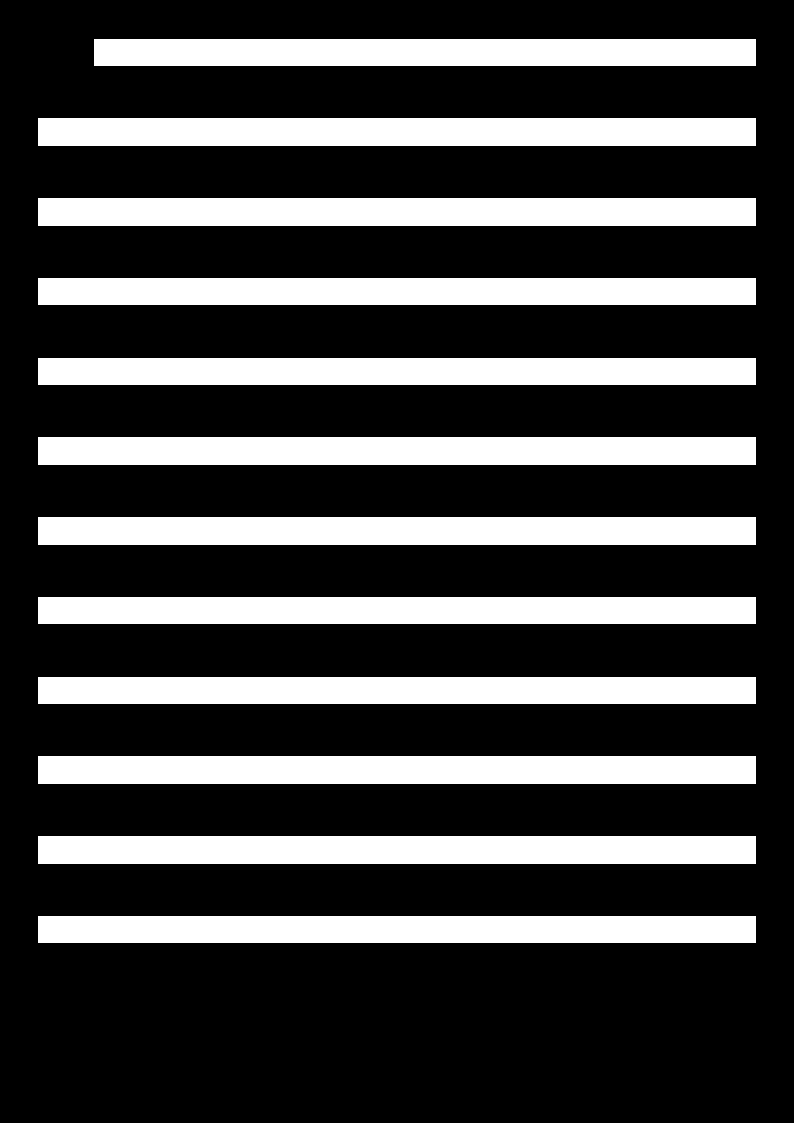

In [6]:
mask_image